# Project 2

In [ ]:
## Import General Libraries
import sys
from google.colab import drive
drive.mount('/content/drive/')
sys.path.append('/content/drive/MyDrive')

!cp drive/MyDrive/plotmat.py .
import plotmat
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from time import time 
np.random.seed(42) 
import random 
random.seed(42)

%pip install 'umap-learn==0.4.6'
!pip install hdbscan


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Clustering of Data

In [ ]:
'''
Create dataset
'''

from sklearn.datasets import fetch_20newsgroups

# Categories we are interested in
comp_categories = [ 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']
rec_categories = ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']

# Create train and test data sets
eight_train = fetch_20newsgroups(subset='train', 
                                  categories=comp_categories+rec_categories, 
                                  shuffle=True, random_state=42,remove = ['headers', 'footers'])
eight_test = fetch_20newsgroups(subset='test', 
                                 categories=comp_categories+rec_categories, 
                                 shuffle=True, random_state=42,remove = ['headers', 'footers'])

In [ ]:
'''
Reassign labels to binary
    comp will get label '0' and rec will get label '1'
'''

binary_labels_train = eight_train.target
binary_labels_test = eight_test.target

for i in np.arange(eight_train.target.shape[0]):
    if eight_train.target[i] < 4:
        binary_labels_train[i] = 0
    else:
        binary_labels_train[i] = 1

for i in np.arange(eight_test.target.shape[0]):
    if eight_test.target[i] < 4:
        binary_labels_test[i] = 0
    else:
        binary_labels_test[i] = 1

print(np.unique(binary_labels_train))
print(np.unique(binary_labels_test))

[0 1]
[0 1]


### Question 1

In [ ]:
'''
Compute TF-IDF Matrices
'''

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


# overwrite analyzer with callable function:
analyzer = CountVectorizer().build_analyzer()

# Apply CountVectorizer to train and test sets
count_vect = CountVectorizer(min_df=3, analyzer=analyzer, stop_words='english')
train_rc_V = count_vect.fit_transform(eight_train.data)
test_rc_V = count_vect.transform(eight_test.data)

# Compute the TF-IDF matrices of the train and test sets
tfidf_trans = TfidfTransformer()
X_train_tfidf = tfidf_trans.fit_transform(train_rc_V)
X_test_tfidf = tfidf_trans.transform(test_rc_V)
print("TF-IDF shape train set: ", X_train_tfidf.shape)
print()
print("TF-IDF shape test set: ", X_test_tfidf.shape)
print()

TF-IDF shape train set:  (4732, 17422)

TF-IDF shape test set:  (3150, 17422)



### Questions 2-3

we might be missing adjusted mutual information score?

In [ ]:
'''
Perform k-means
'''

from sklearn.cluster import KMeans, MiniBatchKMeans


km = KMeans(n_clusters=2, max_iter=1000, n_init=30, random_state = 0,init='k-means++')
km.fit(X_train_tfidf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
       n_clusters=2, n_init=30, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [ ]:
print(km.labels_)
print(binary_labels_train)

[0 0 0 ... 1 0 1]
[1 1 1 ... 1 1 0]


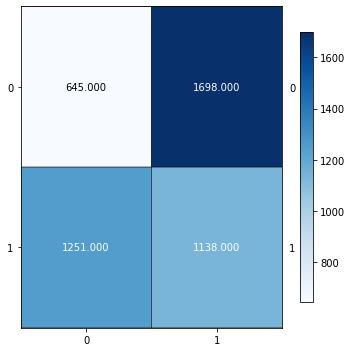

In [ ]:
'''
Plot contingency matrix
'''

from sklearn.metrics.cluster import contingency_matrix


cmatrix_results = contingency_matrix( binary_labels_train,km.labels_) # labels_true, labels_pred
plotmat.plot_mat(cmatrix_results, size=(5,5),)

In [ ]:
'''
Report homogeneity, completeness, V-measure, adjusted Rand Index, and adjusted
mutual information score 
'''

from sklearn import metrics


print("Homogeneity: %0.3f" % metrics.homogeneity_score(binary_labels_train, km.labels_))
print("Adjusted Mutual Information Score: %0.3f" % metrics.adjusted_mutual_info_score(binary_labels_train, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(binary_labels_train, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(binary_labels_train, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(binary_labels_train, km.labels_))
# TODO: adjusted mutual information score

Homogeneity: 0.047
Adjusted Mutual Information Score: 0.047
Completeness: 0.048
V-measure: 0.048
Adjusted Rand-Index: 0.061


## Dimensionality Reduction and Data Transformation

### Question 4

In [ ]:
'''
Perform SVD
'''

from sklearn.decomposition import TruncatedSVD


r=1000
svd_components= TruncatedSVD(n_components=1000)
svd_components.fit(X_train_tfidf)

TruncatedSVD(algorithm='randomized', n_components=1000, n_iter=5,
             random_state=None, tol=0.0)

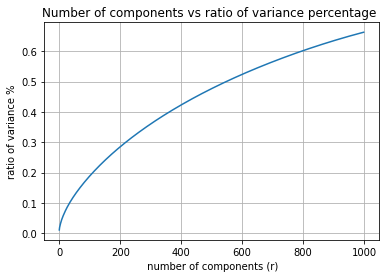

In [ ]:
'''
Observe variance contribution of singular values
'''


plot_components=svd_components.explained_variance_ratio_ # *100

fig, ax = plt.subplots()
ax.plot(range(0,r), np.cumsum(plot_components))
ax.set(xlabel=' number of components (r)', ylabel='ratio of variance %',
       title='Number of components vs ratio of variance percentage ')
ax.grid()
plt.show()

### Question 5

In [ ]:
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.cluster import KMeans
from sklearn import metrics

# Calculates the five performance measurement scores from k-means with varying
# levels of dimensionality reduction
def calc_5_measures(r_values, dim_reduct):

    scores = {"Homogeneity": [],
                  "Completeness": [],
                  "V-measure": [],
                  "Adjusted Rand": [],
                  "Adjusted Mutual Info": []}

    km = KMeans(n_clusters=2, max_iter=1000, n_init=30, random_state = 0,init='k-means++')

    for r in r_values:
        # Reduce dimensions
        if dim_reduct == 'SVD':
            svd_components= TruncatedSVD(n_components=r)
            vals= svd_components.fit_transform(X_train_tfidf)
        elif dim_reduct == 'NMF':
            nmf_components = NMF(n_components=r)
            vals= nmf_components.fit_transform(X_train_tfidf)
        else:
            print('error')
            return 0

        # Compute k-means from dimension reduced data
        km.fit(vals)

        # Store metrics
        scores['Homogeneity'].append(metrics.homogeneity_score(binary_labels_train, 
                                                               km.labels_))
        scores['Completeness'].append(metrics.completeness_score(binary_labels_train, 
                                                                 km.labels_))
        scores['V-measure'].append(metrics.v_measure_score(binary_labels_train,
                                                           km.labels_))
        scores['Adjusted Rand'].append(metrics.adjusted_rand_score(binary_labels_train,
                                                                   km.labels_))
        scores['Adjusted Mutual Info'].append(metrics.adjusted_mutual_info_score(binary_labels_train, 
                                                                                 km.labels_))
    return scores


# Plots the measurement scores as a function of singular values (r)
def plot_r(r_values, score_dict):
    for key in score_dict:
        plt.figure(figsize=(20,5))
        plt.plot(np.log(r_values), score_dict[key])
        plt.xlabel('number of components (r)')
        plt.xticks(np.log(r_values))
        plt.ylabel('score value')
        plt.title(key+" Score")
        plt.show()


In [ ]:
'''
Calculate scores using SVD
'''

r_values = [1, 2, 3, 5, 10, 20, 50, 100, 300]
svd_scores = calc_5_measures(r_values, 'SVD')

for key in svd_scores:
    index = np.argmax(svd_scores[key])
    print(key, ": ", svd_scores[key][index], " r = ", r_values[index])

Homogeneity :  0.07061013414881946  r =  2
Completeness :  0.07359698322288936  r =  2
V-measure :  0.07207262655312106  r =  2
Adjusted Rand :  0.08885229828314813  r =  2
Adjusted Mutual Info :  0.07192816146695036  r =  2


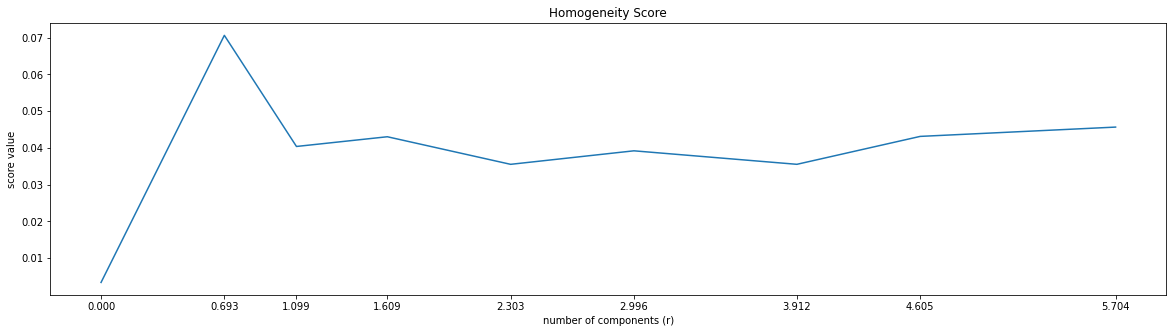

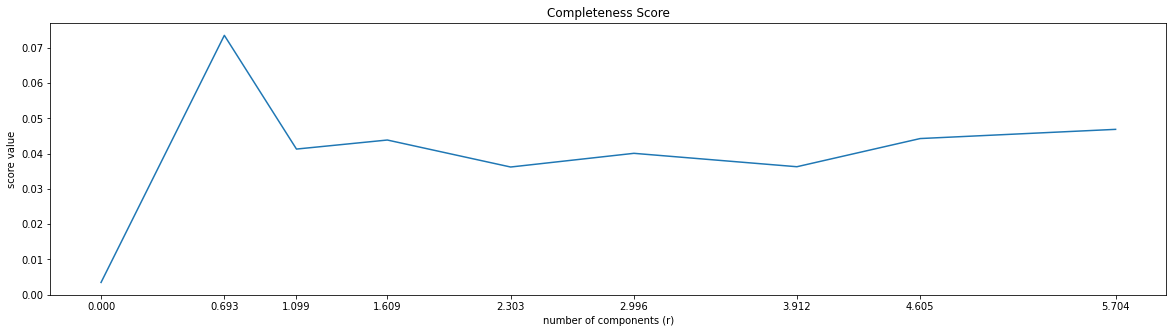

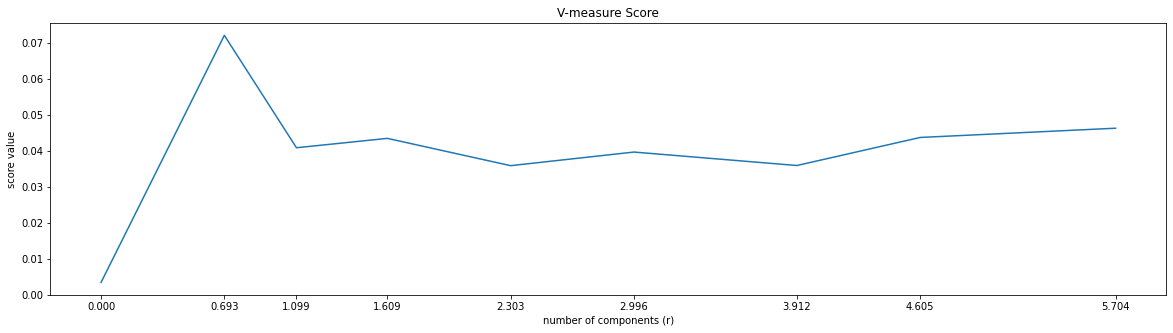

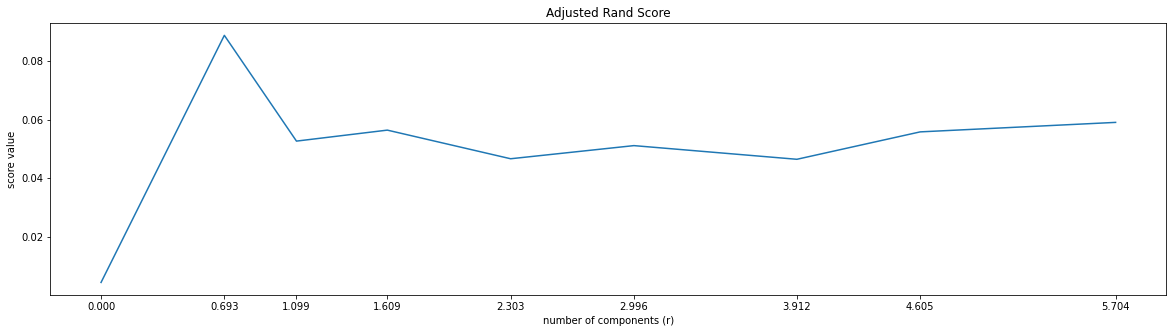

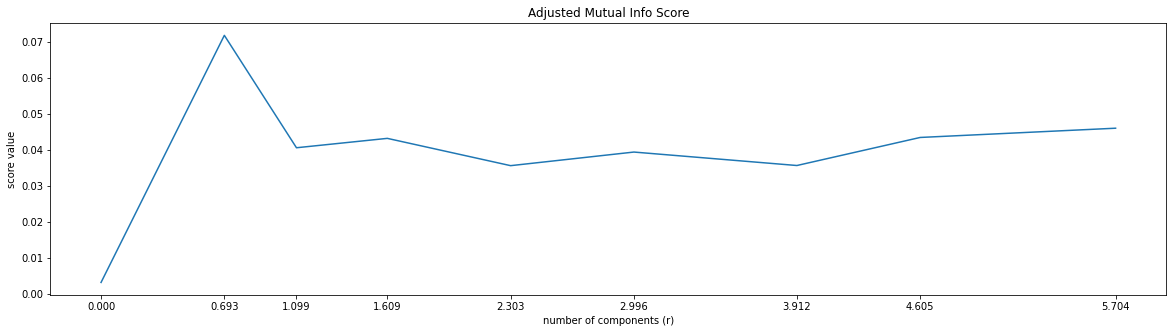

In [ ]:
'''
Plot performance of dimensionality reduction via SVD
'''

plot_r(r_values, svd_scores)

In [ ]:
'''
Calculate scores using NMF
'''

r_values = [1, 2, 3, 5, 10, 20, 50, 100, 300]
nmf_scores = calc_5_measures(r_values, 'NMF')

for key in svd_scores:
    index = np.argmax(nmf_scores[key])
    print(key, ": ", nmf_scores[key][index], " r = ", r_values[index])

KeyboardInterrupt: ignored

In [ ]:
'''
Plot performance of dimensionality reduction via NMF
'''

plot_r(r_values, nmf_scores)

### Question 7

[0 0 0 ... 1 0 1]


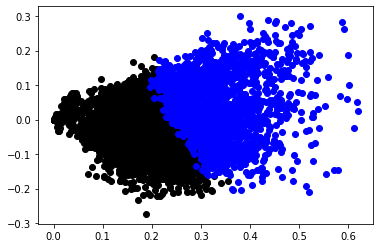

[1 1 1 ... 0 1 0]


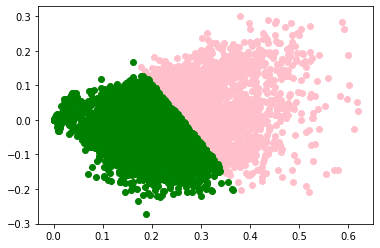

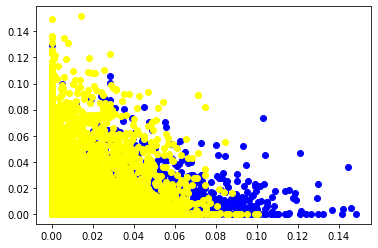

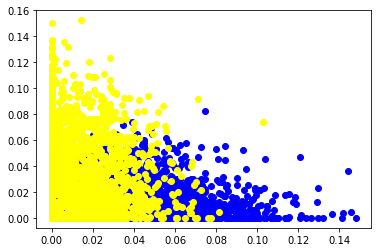

In [ ]:
# print(np.argmax(SVD_h))
# print(np.argmax(SVD_cs))
# print(np.argmax(SVD_ms))
# print(np.argmax(SVD_am))
# print(SVD_h[1]) #r=2?

svd = TruncatedSVD(n_components=2)
vals= svd.fit_transform(X_train_tfidf)
preds=km.labels_

print(preds) #returns labels of each cluster


 
#filter rows of original data
filtered_label0 = vals[preds == 0]
filtered_label1 = vals[preds == 1]

plt.scatter(filtered_label1[:,0] , filtered_label1[:,1] , color = 'black')

 
# plotting the results
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1], color='blue')
#plt.legend()
plt.show()





svd = TruncatedSVD(n_components=2)
vals= svd.fit_transform(X_train_tfidf)
preds=km.fit_predict(vals)

print(preds) #returns labels of each cluster


 
#filter rows of original data
filtered_label0 = vals[preds == 0]
filtered_label1 = vals[preds == 1]



plt.scatter(filtered_label1[:,0] , filtered_label1[:,1] , color = 'pink')
 
# plotting the results
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1], color='green')
#plt.legend()
plt.show()

nmf = NMF(n_components=6)
nmf_vals= nmf.fit_transform(X_train_tfidf)
gt=km.labels_

filtered_label0 = nmf_vals[gt == 0]
filtered_label1 = nmf_vals[gt == 1]



plt.scatter(filtered_label1[:,0] , filtered_label1[:,1] , color = 'blue')

 
# plotting the results
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1], color='yellow')
#plt.legend()
plt.show()



nmf = NMF(n_components=6)
nmf_vals= nmf.fit_transform(X_train_tfidf)
preds=km.fit_predict(nmf_vals)

filtered_label0 = nmf_vals[preds == 0]
filtered_label1 = nmf_vals[preds == 1]



plt.scatter(filtered_label1[:,0] , filtered_label1[:,1] , color = 'blue')

 
# plotting the results
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1], color='yellow')
#plt.legend()
plt.show()



### Question 9

In [ ]:
categories = ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 
              'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 
              'misc.forsale', 'rec.autos', 'rec.motorcycles',
              'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt',
              'sci.electronics', 'sci.med', 'sci.space', 
              'soc.religion.christian','talk.politics.guns', 'talk.politics.mideast',
              'talk.politics.misc', 'talk.religion.misc']
twenty_train = fetch_20newsgroups(subset='train', 
                                  categories=categories, 
                                  shuffle=True, random_state=42,)
twenty_test = fetch_20newsgroups(subset='test', 
                                 categories=categories, 
                                 shuffle=True, random_state=42,)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


# overwrite analyzer with callable function:
analyzer = CountVectorizer().build_analyzer()

# Apply CountVectorizer to train and test sets
count_vect = CountVectorizer(min_df=3, analyzer=analyzer, stop_words='english')
tw_train_rc_V = count_vect.fit_transform(twenty_train.data)
print("Term-freq matrix shape train set: ", tw_train_rc_V.shape)                   # 4732 docs, 16466 terms 
print()
tw_test_rc_V = count_vect.transform(twenty_test.data)
print("Term-freq matrix shape test set: ", tw_test_rc_V.shape)                     # 3150 docs, 16466 terms
print()


In [ ]:
# Compute the TF-IDF matrices of the train and test sets
tfidf_trans = TfidfTransformer()
tw_train_tfidf = tfidf_trans.fit_transform(tw_train_rc_V)
tw_test_tfidf = tfidf_trans.transform(tw_test_rc_V)
print("TF-IDF shape train set: ", tw_train_tfidf.shape)
print()
print("TF-IDF shape test set: ", tw_test_tfidf.shape)
print()

In [ ]:
svd = TruncatedSVD(n_components=20, random_state=42)
tw_train_LSI = svd.fit_transform(tw_train_tfidf)
tw_test_LSI = svd.fit_transform(tw_test_tfidf)

print("SVD shape train set: ", tw_train_LSI.shape)
print()
print("SVD shape test set: ", tw_test_LSI.shape)
print()


In [ ]:
km = KMeans(n_clusters=20, max_iter=1000, n_init=30, random_state = 0,init='k-means++')
km.fit(tw_train_LSI)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(twenty_train.target, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(twenty_train.target, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(twenty_train.target, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(twenty_train.target, km.labels_))

In [ ]:
cmatrix_results = contingency_matrix(twenty_train.target,km.labels_) # labels_true, labels_pred
#plot_mat(cmatrix_results, size=(20,20),)
from scipy.optimize import linear_sum_assignment
rows, cols = linear_sum_assignment(cmatrix_results, maximize=True)
plot_mat(cmatrix_results[rows[:, np.newaxis], cols], xticklabels=cols,yticklabels=rows, size=(15,15))

### Question 10

In [ ]:
from sklearn.decomposition import NMF


nmf = NMF(n_components=20, init='random', random_state=42, beta_loss='kullback-leibler', solver = 'mu')
tw_NMF_train = nmf.fit_transform(tw_train_tfidf)
tw_NMF_test = nmf.fit_transform(tw_test_tfidf)

print(tw_NMF_train.shape)

In [ ]:
km = KMeans(n_clusters=20, max_iter=1000, n_init=30, random_state = 0,init='k-means++')
km.fit(tw_NMF_train)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(twenty_train.target, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(twenty_train.target, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(twenty_train.target, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(twenty_train.target, km.labels_))

### Question 11

In [ ]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


# Create train and test data sets
twenty_train = fetch_20newsgroups(subset='train', 
                                  shuffle=True, random_state=42,remove = ['headers', 'footers'])

# overwrite analyzer with callable function:
analyzer = CountVectorizer().build_analyzer()

# Apply CountVectorizer to train sets
count_vect = CountVectorizer(min_df=3, analyzer=analyzer, stop_words='english')
train_rc_V = count_vect.fit_transform(twenty_train.data)

# Compute the TF-IDF matrices of the train and test sets
tfidf_trans = TfidfTransformer()
X_train_tfidf = tfidf_trans.fit_transform(train_rc_V)
print("TF-IDF shape train set: ", X_train_tfidf.shape)
print()

In [ ]:
import umap
from sklearn.cluster import KMeans
from sklearn import metrics

# Calculates the five performance measurement scores from k-means with varying
# levels of dimensionality reduction
def find_num_components(n_compenents):

    scores = {"Homogeneity": [],
                  "Completeness": [],
                  "V-measure": [],
                  "Adjusted Rand": [],
                  "Adjusted Mutual Info": []}

    km = KMeans(n_clusters=20, max_iter=1000, n_init=30, random_state = 0,init='k-means++')

    for n in num_components:
        print(n)
        # Reduce dimensions
        umap_dims = umap.UMAP(n_components=n, metric='cosine')
        u = umap_dims.fit_transform(X_train_tfidf)  

        # Compute k-means from dimension reduced data
        km.fit(u)

        # Store metrics
        scores['Homogeneity'].append(metrics.homogeneity_score(twenty_train.target, 
                                                               km.labels_))
        scores['Completeness'].append(metrics.completeness_score(twenty_train.target, 
                                                                 km.labels_))
        scores['V-measure'].append(metrics.v_measure_score(twenty_train.target,
                                                           km.labels_))
        scores['Adjusted Rand'].append(metrics.adjusted_rand_score(twenty_train.target,
                                                                   km.labels_))
        scores['Adjusted Mutual Info'].append(metrics.adjusted_mutual_info_score(twenty_train.target, 
                                                                                 km.labels_))
    return scores

In [ ]:
'''
Find a good number of components for UMAP
'''

num_components = [1, 2, 5, 10, 20, 50, 100, 250]
u_scores = find_num_components(num_components)

for key in u_scores:
    index = np.argmax(u_scores[key])
    print(key, ": ", u_scores[key][index], " r = ", num_components[index])

plot_r(num_components, u_scores)

In [ ]:
'''
UMAP and K-means with metric = ' euclidean'
'''

import umap
from sklearn.cluster import KMeans


# best number of components from above 
n = 20

# Reduce dimensions with 'euclidean'
umap_euc = umap.UMAP(n_components=n, metric='euclidean')
u_euc = umap_euc.fit_transform(X_train_tfidf)  

# Compute k-means from dimension reduced data
km = KMeans(n_clusters=20, max_iter=1000, n_init=30, random_state = 0,init='k-means++')
km.fit(u_euc)

# report five performance metrics
print()
print("Evaluation Metrics for metric='euclidean'")
print(print_evaluation_metrics(twenty_train.target, km.labels_))
print()

In [ ]:
'''
UMAP and K-means w/ metric='cosine'
'''

# best number of components from above 
n = 20

# Reduce dimensions with 'cosine'
umap_cos = umap.UMAP(n_components=n, metric='cosine')
u_cos = umap_cos.fit_transform(X_train_tfidf)  

# Compute k-means from dimension reduced data
km = KMeans(n_clusters=20, max_iter=1000, n_init=30, random_state = 0,init='k-means++')
km.fit(u_cos)

# report five performance metrics
print()
print("Evaluation Metrics for metric='cosine'")
print(print_evaluation_metrics(twenty_train.target, km.labels_))
print()

### Question 12

In [ ]:
'''
Print contingency matrix for UMAP w/ metric='cosine'
'''

from sklearn.metrics.cluster import contingency_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix


# print contingency matrix
print("Contingency Matrix for metric='cosine")
cmatrix_results = contingency_matrix(twenty_train.target,km.labels_) 
rows, cols = linear_sum_assignment(cmatrix_results, maximize=True)
plotmat.plot_mat(cmatrix_results[rows[:, np.newaxis], cols],
                 xticklabels=cols,
                 yticklabels=rows,
                 size=(15,15))

### Question 13


In [ ]:
'''
Reduce dimensions with UMAP
'''

import umap


# best number of components from above 
n = 20

# Reduce dimensions with 'cosine'
umap_cos = umap.UMAP(n_components=n, metric='cosine')
u_cos = umap_cos.fit_transform(X_train_tfidf) 

In [ ]:
'''
Agglomerative clustering w/ linkage='ward'
'''

from sklearn.cluster import AgglomerativeClustering

 
# Compute Agglomerative Clustering
ag = AgglomerativeClustering(n_clusters=20, linkage='ward')
ag.fit(u_cos)

# report five performance metrics
print()
print("Evaluation Metrics for metric='cosine'")
print(print_evaluation_metrics(twenty_train.target, ag.labels_))
print()

In [ ]:
'''
Agglomerative clustering w/ linkage='single'
'''

import umap
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering

# best number of components from above 
n = 5

# Reduce dimensions with 'cosine'
umap_cos = umap.UMAP(n_components=n, metric='cosine')
u_cos = umap_cos.fit_transform(X_train_tfidf)  

# Compute Agglomerative Clustering from dimension reduced data
ag = AgglomerativeClustering(n_clusters=20, linkage='single')
ag.fit(u_cos)

# report five performance metrics
print()
print("Evaluation Metrics for metric='cosine'")
print(print_evaluation_metrics(twenty_train.target, ag.labels_))
print()

### Question 14

In [ ]:
'''
Reduce dimensionality of data with UMAP
'''

import umap


# best number of components from above 
n = 20

# Reduce dimensions with 'cosine'
umap_cos = umap.UMAP(n_components=n, metric='cosine')
u_cos = umap_cos.fit_transform(X_train_tfidf)  

In [ ]:
'''
Hyperparameter search for DBSCAN
'''

from sklearn.cluster import DBSCAN

scores = {"Homogeneity": np.zeros((5,3)),
          "Completeness": np.zeros((5,3)),
          "V-measure": np.zeros((5,3)),
          "Adjusted Rand": np.zeros((5,3)),
          "Adjusted Mutual Info": np.zeros((5,3))}

EPS_OPTIONS = np.array([0.3, 0.4, 0.5, 0.6, 0.7])
DIST_OPTIONS = np.array(['l1', 'euclidean', 'cosine'])

# Compute DBSCAN with variety of paramters
for eps in EPS_OPTIONS:
    for dist in DIST_OPTIONS:
        db = DBSCAN(min_samples=100, eps=eps, metric=dist)
        db.fit(u_cos)

        row = np.where(EPS_OPTIONS == eps)[0]
        col = np.where(DIST_OPTIONS == dist)[0]

        scores['Homogeneity'][row, col] = metrics.homogeneity_score(twenty_train.target, 
                                                                    db.labels_)
        scores['Completeness'][row, col] = metrics.completeness_score(twenty_train.target, 
                                                                      db.labels_)
        scores['V-measure'][row, col] = metrics.v_measure_score(twenty_train.target,
                                                                db.labels_)
        scores['Adjusted Rand'][row, col] = metrics.adjusted_rand_score(twenty_train.target,
                                                                        db.labels_)
        scores['Adjusted Mutual Info'][row, col] = metrics.adjusted_mutual_info_score(twenty_train.target,
                                                                                      db.labels_)


In [ ]:
'''
Find optimal paramters
'''

for key in scores:
    print(key)
    print(scores[key])
    print()

    ind = np.unravel_index(np.argmax(scores[key], axis=None), scores[key].shape)
    print(scores[key][ind], "    eps = ", EPS_OPTIONS[ind[0]], "    dist = ", DIST_OPTIONS[ind[1]])
    print()
    print()


In [ ]:
'''
DBSCAN w/ optimal parameters
'''

from sklearn.cluster import DBSCAN

# optimal parameters
eps = 0.6
dist = 'euclidean'

# Apply DBSCAN
db = DBSCAN(min_samples=100, eps=eps, metric=dist)
db.fit(u_cos)

# report five performance metrics
print()
print("Evaluation Metrics for DBSCAN'")
print(print_evaluation_metrics(twenty_train.target, db.labels_))
print()

In [ ]:
'''
Hyperparameter search for HDBSCAN
'''

from hdbscan import HDBSCAN


EPS_OPTIONS = np.array([0.30, 0.40, 0.50, 0.60, 0.70])
DIST_OPTIONS = np.array(['l1', 'euclidean'])

scores = {"Homogeneity": np.zeros((5,2)),
          "Completeness": np.zeros((5,2)),
          "V-measure": np.zeros((5,2)),
          "Adjusted Rand": np.zeros((5,2)),
          "Adjusted Mutual Info": np.zeros((5,2))}

# Compute HDBSCAN 
for eps in EPS_OPTIONS:
    eps = float(eps)
    for dist in DIST_OPTIONS:
        hdb = HDBSCAN(min_cluster_size=100, 
                      cluster_selection_epsilon= eps,
                      metric=dist)
        hdb.fit(u_cos)

        row = np.where(EPS_OPTIONS == eps)
        col = np.where(DIST_OPTIONS == dist)

        scores['Homogeneity'][row, col] = metrics.homogeneity_score(twenty_train.target, 
                                                                    hdb.labels_)
        scores['Completeness'][row, col] = metrics.completeness_score(twenty_train.target, 
                                                                      hdb.labels_)
        scores['V-measure'][row, col] = metrics.v_measure_score(twenty_train.target,
                                                                hdb.labels_)
        scores['Adjusted Rand'][row, col] = metrics.adjusted_rand_score(twenty_train.target,
                                                                        hdb.labels_)
        scores['Adjusted Mutual Info'][row, col] = metrics.adjusted_mutual_info_score(twenty_train.target,
                                                                                      hdb.labels_)

In [ ]:
'''
Find optimal parameters
'''

for key in scores:
    print(key)
    print(scores[key])
    print()

    ind = np.unravel_index(np.argmax(scores[key], axis=None), scores[key].shape)
    print(scores[key][ind], "    eps = ", EPS_OPTIONS[ind[0]], "    dist = ", DIST_OPTIONS[ind[1]])
    print()
    print()

In [ ]:
'''
HDBSCAN w/ optimal paramters
'''

from hdbscan import HDBSCAN


# optimal parameters
eps = 0.3
dist = 'euclidean'

# Apply HDBSCAN
hdb = HDBSCAN(min_cluster_size=100, cluster_selection_epsilon=eps, metric=dist)
hdb.fit(u_cos)

# report five performance metrics
print()
print("Evaluation Metrics for HDBSCAN'")
print(print_evaluation_metrics(twenty_train.target, hdb.labels_))
print()

### Question 15

In [ ]:
'''
Print contingency matrix for best model from question 14
'''

from sklearn.metrics.cluster import contingency_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix


# best model: DBSCAN w/ eps = 0.6 and dist = 'euclidean'
db = DBSCAN(min_samples=100, eps=0.6, metric='euclidean')
db.fit(u_cos)

# print contingency matrix
print("Contingency Matrix for DBSCAN")
cmatrix_results = contingency_matrix(twenty_train.target,db.labels_) 
rows, cols = linear_sum_assignment(cmatrix_results, maximize=True)
plotmat.plot_mat(cmatrix_results[rows[:, np.newaxis], cols],
                 xticklabels=cols,
                 yticklabels=rows,
                 size=(15,15))

###Question 16


In [28]:
from google.colab import files
import numpy as np
from google.colab import drive
import pandas as pd
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer




drive.mount('/content/drive')
bbc_train = pd.read_csv("drive/My Drive/BBC News Train.csv")
#bbc_train['category_id'] = bbc_train['Category'].factorize()[0]
#print(bbc_train.Text)
analyzer = CountVectorizer().build_analyzer()
count_vect = CountVectorizer(min_df=3, analyzer=analyzer, stop_words='english')
train_rc_V = count_vect.fit_transform(bbc_train.Text)

print("Term-freq matrix shape train set: ", train_rc_V.shape)                
print()



tfidf_trans = TfidfTransformer()
X_train_tfidf = tfidf_trans.fit_transform(train_rc_V)


print("TF-IDF shape train set: ", X_train_tfidf.shape)
print()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Term-freq matrix shape train set:  (1490, 10557)

TF-IDF shape train set:  (1490, 10557)



In [30]:
num_lbl_tr = []

#print(len(num_lbl_tr))
#print(X_train_tfidf.shape[0])
for i in range(X_train_tfidf.shape[0]):
    if bbc_train.Category[i] == 'politics':
      num_lbl_tr.append(0)
    if bbc_train.Category[i] == 'business':
      num_lbl_tr.append(1)
    if bbc_train.Category[i] == 'tech':
      num_lbl_tr.append(2)
    if bbc_train.Category[i] == 'entertainment':
      num_lbl_tr.append(3)
    if bbc_train.Category[i] == 'sport':
      num_lbl_tr.append(4)
print(len(num_lbl_tr))


1490


In [31]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import metrics



km = KMeans(n_clusters=5, max_iter=1000, n_init=30, random_state = 0,init='k-means++')
km.fit(X_train_tfidf)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(num_lbl_tr, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(num_lbl_tr, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(num_lbl_tr, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(num_lbl_tr, km.labels_))
print("Adjusted Mutual Information Score: %0.3f" % metrics.adjusted_mutual_info_score(num_lbl_tr, km.labels_))

Homogeneity: 0.701
Completeness: 0.709
V-measure: 0.705
Adjusted Rand-Index: 0.704
Adjusted Mutual Information Score: 0.704
